In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

plt.style.use('dark_background')

2023-05-24 12:28:21.629868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df=pd.read_csv('mitbih_train.csv',header=None)

In [3]:
print(df.shape)

(87554, 188)


In [4]:
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 4234)

In [7]:
print(train_data.shape)
print(test_data.shape)

(70043, 187)
(17511, 187)


In [8]:
# 데이터 정규화
min_value = train_data.min()
max_value = train_data.max()

train_data = (train_data - min_value) / (max_value - min_value)


test_data = (test_data - min_value) / (max_value - min_value)
print(min_value)
print(max_value)

0.0
1.0


In [9]:

# 데이터 변환
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [10]:
# Normal ECG
normal_train = train_data[train_labels]
normal_test = test_data[test_labels]

# Anoraml ECG 
anormal_train = train_data[~train_labels]
anormal_test = test_data[~test_labels]

In [13]:
print(normal_train.shape, normal_test.shape)
print(anormal_train.shape, anormal_test.shape)

(12026, 187) (3057, 187)
(58017, 187) (14454, 187)


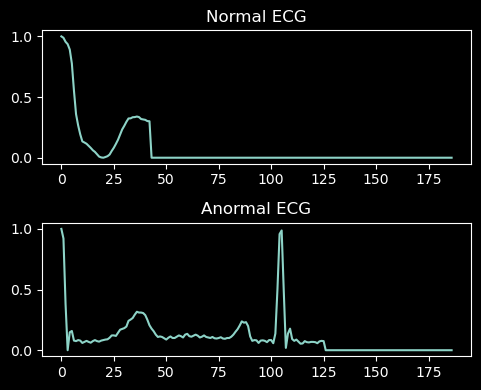

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(5, 4))  # Create a figure with two subplots

# Plot normal ECG
axes[0].plot(np.arange(187), normal_train[10])
axes[0].set_title('Normal ECG')

# Plot abnormal ECG
axes[1].plot(np.arange(187), anormal_train[10])
axes[1].set_title('Anormal ECG')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


2023-05-24 19:10:40.552690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
121/121 [==============================] - 2s 4ms/step - loss: 0.0369 - accuracy: 0.2673 - val_loss: 0.0216 - val_accuracy: 0.2790
Epoch 2/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.2844 - val_loss: 0.0199 - val_accuracy: 0.2627
Epoch 3/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.2862 - val_loss: 0.0156 - val_accuracy: 0.2915
Epoch 4/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.2965 - val_loss: 0.0135 - val_accuracy: 0.3039
Epoch 5/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.2978 - val_loss: 0.0128 - val_accuracy: 0.2954
Epoch 6/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.2978 - val_loss: 0.0131 - val_accuracy: 0.2872
Epoch 7/500
121/121 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.2955 - val_loss: 0.0113 - val_accuracy: 0.3016

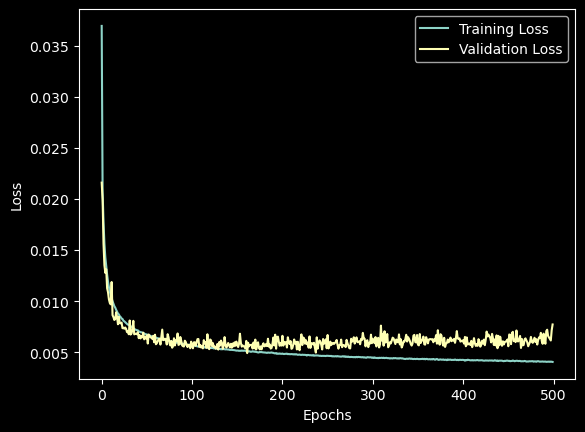

In [15]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),  # Dropout layer for regularization
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),  # Dropout layer for regularization
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(187, activation='sigmoid')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AutoEncoder()
autoencoder.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(normal_train, normal_train, epochs=500, batch_size=100, validation_data=(normal_test, normal_test))

# Get the training loss values
train_loss = history.history['loss']

# Get the validation loss values
val_loss = history.history['val_loss']

# Plot the loss graph
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



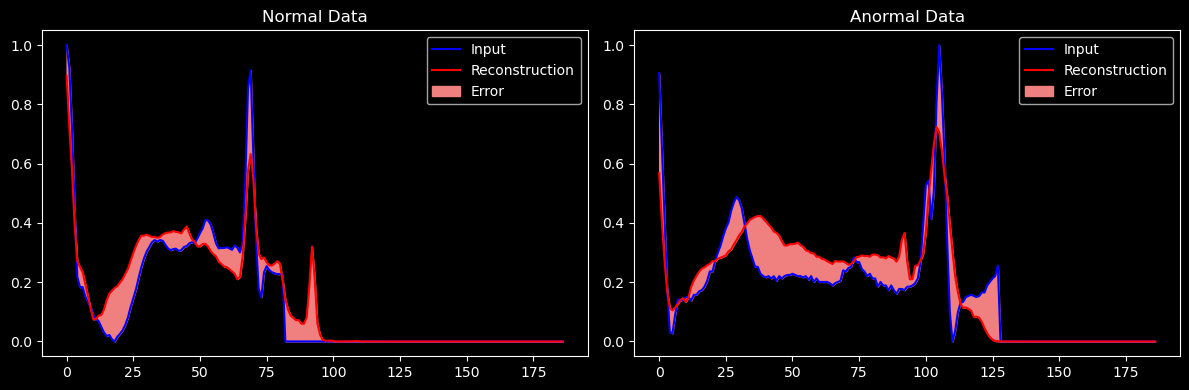

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot(data1, data2, n):
    enc_img1 = autoencoder.encoder(data1)
    dec_img1 = autoencoder.decoder(enc_img1)
    enc_img2 = autoencoder.encoder(data2)
    dec_img2 = autoencoder.decoder(enc_img2)

    plt.figure(figsize=(12, 4))

    # 첫 번째 데이터의 입력과 재구성 그래프
    plt.subplot(1, 2, 1)
    plt.plot(data1[n], 'b')
    plt.plot(dec_img1[n], 'r')
    plt.fill_between(np.arange(187), data1[n], dec_img1[n], color='lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.title('Normal Data')

    # 두 번째 데이터의 입력과 재구성 그래프
    plt.subplot(1, 2, 2)
    plt.plot(data2[n], 'b')
    plt.plot(dec_img2[n], 'r')
    plt.fill_between(np.arange(187), data2[n], dec_img2[n], color='lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.title('Anormal Data')

    plt.tight_layout()
    plt.show()

plot(normal_test, anormal_test, 0)

